In [1]:
!pip install scikit-optimize

### We developed in colab, please skip this line

In [25]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [26]:
import pandas as pd
from sklearn import compose, feature_selection, preprocessing, svm, model_selection, pipeline, metrics
import numpy as np
import seaborn as sns
from skopt import BayesSearchCV, space

BASE_PATH = './'
TARGET_FOLDER = 'classification_split'

RANDOM_STATE=0

In [4]:
df = pd.read_excel(f'{BASE_PATH}/TrainDataset2023.xlsx')

In [5]:
df = df[df['pCR (outcome)'] != 999].reset_index(drop=True)
len(df)

395

In [6]:
df_train, df_test = model_selection.train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=df['pCR (outcome)']
    )

In [7]:
df_train = df_train.drop(columns=['ID', 'RelapseFreeSurvival (outcome)']).reset_index(drop=True)
df_test = df_test.drop(columns=['ID', 'RelapseFreeSurvival (outcome)']).reset_index(drop=True)

In [8]:
all_features = df_train.columns.tolist()[1:]
target_col = 'pCR (outcome)'

In [9]:
categorical_cols = ['ER',
"PgR",
"HER2",
'TrippleNegative',
'ChemoGrade',
'Proliferation',
'HistologyType',
'LNStatus',
'TumourStage']

numerical_cols = [col for col in all_features if col not in categorical_cols]

z_numerical_cols = []

In [10]:
df_train['Age_group'] = 0
df_test['Age_group'] = 0

fillna_mappers = {}

for i in range(10):
  df_train.loc[df_train['Age'] > 10*i, 'Age_group' ] = i
  df_test.loc[df_test['Age'] > 10*i, 'Age_group' ] = i

for cat_col in categorical_cols:
  df_train.loc[df_train[cat_col] == 999]
  fillna_mapper = dict(df_train.groupby(['Age_group'])[cat_col].agg(lambda x: pd.Series.mode(x).iat[0]))
  df_train.loc[df_train[cat_col] == 999, cat_col] = df_train.loc[df_train[cat_col]==999]["Age_group"].map(fillna_mapper)
  df_test.loc[df_test[cat_col] == 999, cat_col] = df_test.loc[df_test[cat_col]==999]["Age_group"].map(fillna_mapper)
  fillna_mappers[cat_col] = fillna_mapper

In [11]:
mean_dict = {}
std_dict = {}

for numerical_col in numerical_cols:
  if numerical_col != "Age":
    mean_dict_ = dict(df_train.groupby(['Age_group'])[numerical_col].mean())
    std_dict_ = dict(df_train.groupby(['Age_group'])[numerical_col].std())
    mean_dict[numerical_col] = mean_dict_
    std_dict[numerical_col] = std_dict_

    df_ = df_train[[numerical_col, 'Age_group']].copy()
    df_['mean'] = df_['Age_group'].map(mean_dict[numerical_col])
    df_['std'] = df_['Age_group'].map(std_dict[numerical_col])
    df_train[f"z_{numerical_col}"] = (df_train[numerical_col] - df_['mean'])/(df_['std'])

    df_ = df_test[[numerical_col, 'Age_group']].copy()
    df_['mean'] = df_['Age_group'].map(mean_dict[numerical_col])
    df_['std'] = df_['Age_group'].map(std_dict[numerical_col])
    df_test[f"z_{numerical_col}"] = (df_test[numerical_col] - df_['mean'])/(df_['std'])

    z_numerical_cols.append(f"z_{numerical_col}")

In [12]:
all_features = numerical_cols + z_numerical_cols + categorical_cols

In [13]:
power_transform = preprocessing.PowerTransformer()
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = preprocessing.MinMaxScaler()

X_train_num, X_train_cat, y_train = df_train[numerical_cols + z_numerical_cols], df_train[categorical_cols].astype('category'), df_train[target_col].values
X_train_num = power_transform.fit_transform(X_train_num)
X_train_num = scaler.fit_transform(X_train_num)
X_train_cat = one_hot_encoder.fit_transform(X_train_cat)
X_train_cat = X_train_cat.toarray()
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)

kfold = model_selection.StratifiedKFold(5, random_state=0, shuffle=True)

svc = svm.SVC(C=0.05, kernel="linear", class_weight="balanced")

sfs = feature_selection.SequentialFeatureSelector(
    svc,
    n_features_to_select=17, #sqrt(316)
    cv=kfold,
    scoring = 'balanced_accuracy',
    )
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                          estimator=SVC(C=0.05, class_weight='balanced',
                                        kernel='linear'),
                          n_features_to_select=17, scoring='balanced_accuracy')

In [14]:
X_train_reduced = sfs.transform(X_train)
X_train_reduced

array([[0.66665535, 0.5545207 , 0.29072123, ..., 0.        , 0.        ,
        1.        ],
       [0.6653396 , 0.84710047, 0.40655826, ..., 1.        , 0.        ,
        0.        ],
       [0.58207892, 0.73697546, 0.36656011, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.60968046, 0.78991398, 0.4065414 , ..., 1.        , 0.        ,
        0.        ],
       [0.67092358, 0.62627895, 0.30037681, ..., 1.        , 0.        ,
        0.        ],
       [0.54998175, 0.50864443, 0.32916071, ..., 0.        , 1.        ,
        0.        ]])

In [15]:
model = svm.SVC(class_weight="balanced")

search_space = {
    "kernel": space.Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": space.Integer(1, 10),
    #"C": space.Categorical([0.001, 0.05, 0.1, 1, 10])
    "C": space.Real(0.01,1),

}

opt = BayesSearchCV(
    model,
    search_space,
    cv=kfold,
    n_iter=100,
    scoring = 'balanced_accuracy',
    random_state=0,
    verbose=1
    )

opt.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
              estimator=SVC(class_weight='balanced'), n_iter=100,
              random_state=0, scoring='balanced_accuracy',
              search_spaces={'C': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'degree': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'kernel': Categorical(categories=('linear', 'poly', 'rbf', 'sigmoid'), prior=None)},
              verbose=1)

In [16]:
opt.best_score_

0.6737488226059654

In [17]:
opt.best_params_

OrderedDict([('C', 0.10113395193616369), ('degree', 9), ('kernel', 'rbf')])

In [18]:
model = opt.best_estimator_
X_test_num, X_test_cat, y_test = df_test[numerical_cols + z_numerical_cols], df_test[categorical_cols].astype('category'), df_test[target_col].values
X_test_num = power_transform.transform(X_test_num)
X_test_num = scaler.transform(X_test_num)
X_test_cat = one_hot_encoder.transform(X_test_cat)
X_test_cat = X_test_cat.toarray()
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)
X_test

X_test_reduced = sfs.transform(X_test)
X_test_reduced

y_pred = model.predict(X_test_reduced)

In [19]:
test_conf = metrics.confusion_matrix(y_test, y_pred)

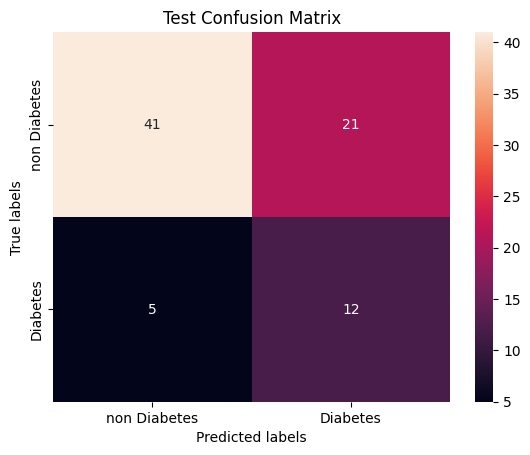

In [20]:
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(test_conf, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['non Diabetes', 'Diabetes']);
ax.yaxis.set_ticklabels(['non Diabetes', 'Diabetes']);

In [21]:
metrics.balanced_accuracy_score(y_test, y_pred)

0.6835863377609108

In [ ]:
import pickle

with open(f'{BASE_PATH}/fillna_mappers_classification.pkl', 'wb') as file:
  pickle.dump(fillna_mappers, file)

with open(f'{BASE_PATH}/numerical_cols_classification.pkl', 'wb') as file:
  pickle.dump(numerical_cols, file)

with open(f'{BASE_PATH}/categorical_cols_classification.pkl', 'wb') as file:
  pickle.dump(categorical_cols, file)

with open(f'{BASE_PATH}/z_numerical_cols_classification.pkl', 'wb') as file:
  pickle.dump(z_numerical_cols, file)

with open(f'{BASE_PATH}/power_transform_classification.pkl', 'wb') as file:
  pickle.dump(power_transform, file)

with open(f'{BASE_PATH}/one_hot_encoder_classification.pkl', 'wb') as file:
  pickle.dump(one_hot_encoder, file)

with open(f'{BASE_PATH}/scaler_classification.pkl', 'wb') as file:
  pickle.dump(scaler, file)

with open(f'{BASE_PATH}/sfs_classification.pkl', 'wb') as file:
  pickle.dump(sfs, file)

with open(f'{BASE_PATH}/classification_model.pkl', 'wb') as file:
  pickle.dump(model, file)

with open(f'{BASE_PATH}/mean_dict_classification.pkl', 'wb') as file:
  pickle.dump(mean_dict, file)

with open(f'{BASE_PATH}/std_dict_classification.pkl', 'wb') as file:
  pickle.dump(std_dict, file)
